# Data preparation

In [1]:
from lib import *

0        0
1        1
2        0
3        0
4        1
        ..
43195    1
43196    2
43197    2
43198    0
43199    2
Name: Avg. Readers_Joy, Length: 43200, dtype: int64
0        [0, 2, 0, 0, 0, 0, 0, 0]
1        [1, 0, 0, 2, 0, 0, 0, 0]
2        [0, 0, 0, 1, 0, 0, 0, 0]
3        [0, 1, 0, 0, 0, 0, 1, 0]
4        [1, 0, 0, 1, 0, 0, 0, 0]
                   ...           
43195    [1, 0, 0, 1, 0, 0, 0, 0]
43196    [2, 0, 2, 0, 0, 0, 0, 0]
43197    [2, 0, 0, 0, 0, 0, 0, 0]
43198    [0, 0, 2, 0, 0, 0, 0, 0]
43199    [2, 0, 0, 0, 0, 0, 0, 1]
Name: readers_emotion_intensities, Length: 43200, dtype: object


In [2]:
# reindex
df_wrime_target = df_wrime_target.reset_index(drop=True)
# df_wrime_target.info()

In [3]:
sentences = df_wrime_target['Sentence'].tolist()

# replace '\n' with ''
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# replace 'x000D' with ''
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# Prepare embeddings of tweets based on emotional intensities. 

In [4]:
flag = "word2vec" #  "pretrained" # "fine_tuned" # or  or 

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Load pretrained model/tokenizer. 
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

embedding_path = "output"
if not os.path.isdir(embedding_path):
    os.makedirs(embedding_path)

if flag == "pretrained":
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=True allows us to access hidden states. 
    path_to_embeddings = os.path.join(embedding_path, 'pretrained_embeddings.tsv')
    permutation_for_cluster_IDs = [5, 2, 4, 6, 3, 1]

elif flag == "fine_tuned":
    # model = AutoModelForSequenceClassification.from_pretrained("trained_model", output_hidden_states=True) # output_hidden_states=True allows us to access hidden states.
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join("output", "trained_model"), output_hidden_states=True) # output_hidden_states=True allows us to access hidden states.
    path_to_embeddings = os.path.join(embedding_path, 'fine-tuned_embeddings.tsv')
    permutation_for_cluster_IDs = [2, 3, 1, 4, 5, 6]

elif flag == "word2vec":
    path_to_embeddings = os.path.join(embedding_path, 'word2vec_embeddings.tsv')
    permutation_for_cluster_IDs = [1, 2, 3, 4, 5, 6] # To-do: change this to ?

if os.path.isfile(path_to_embeddings):
    df_embeddings = pd.read_table(path_to_embeddings, header=None)
else:
    if flag == "word2vec":
        df_embeddings = make_embeddings_by_word2vec(sentences, path_to_embeddings)
    else:
        df_embeddings = make_embeddings_by_bert(sentences, tokenizer, model, path_to_embeddings)

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['今日', 'の', '月', 'も', '白く', 'て', '明るい', '。', '昨日', 'より', '雲', 'が', '少なく', 'て', 'キレイ', 'な', '?', 'と', '立ち止まる', '帰り道', '｡', 'チャリ', 'なし', '生活', 'も', '悪く', 'ない', '｡']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Columns: 768 entries, 0 to 767
dtypes: float32(768)
memory usage: 53.4 MB


---

# K-means clustering by embeddings. 

In [6]:
from sklearn.cluster import KMeans

k = 6 # number of clusters
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# Cluster ID (0-based) for each tweet. 
clusters = kmeansModel.labels_
# Cluster ID is 1-based. 
clusters = clusters + 1
print(kmeansModel.labels_)
print(len(kmeansModel.labels_))
print(clusters)

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[5 2 5 ... 2 2 2]
18237
[6 3 6 ... 3 3 3]


In [7]:
# Load the intensity-based clusters
_df = pd.read_csv(os.path.join('output', 'emotion_6_clusters.tsv'), sep='\t', header=None)
# emotion_clusters = _df[0].tolist()
# emotion_clusters = [int(x) for x in emotion_clusters]
emotion_clusters = [int(x) for x in _df[0].tolist()]
df_intensity_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])
df_intensity_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


## Comparison of the pretrain model embedding-based clusters with the intensity-based clusters. 

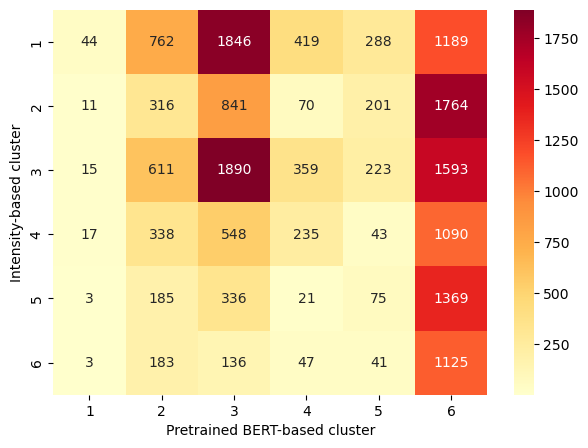

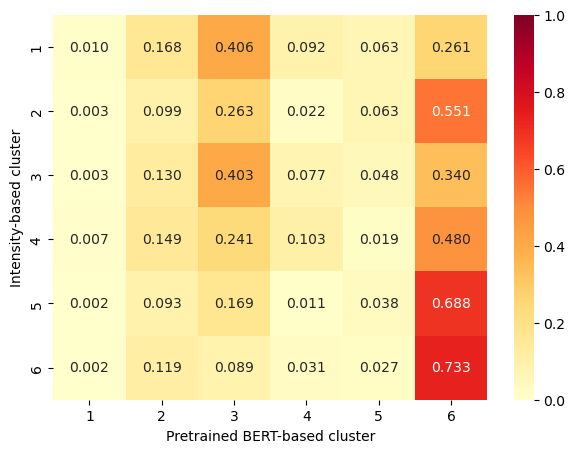

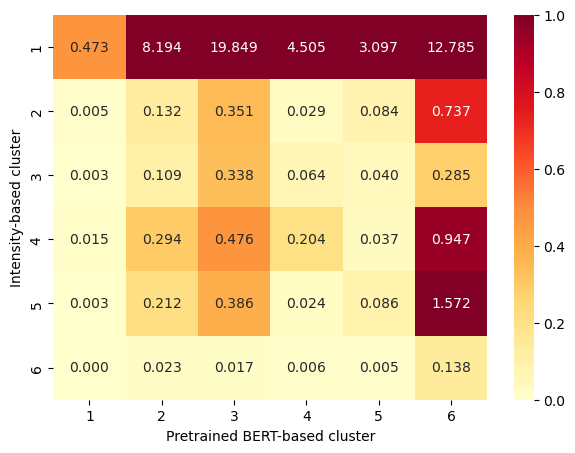

In [8]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
conf_mat = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters))) # confusion matrix
conf_mat_norm_by_row = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row. 
conf_mat_norm_by_column = conf_mat.astype('float') / conf_mat.sum(axis=0)[:, np.newaxis] # Normalize the confusion matrix by row. 

# Heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_row, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_column, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()


In [9]:
# Rename cluster IDs for pretrain or fine-tuning
# pretrained
# clusters[clusters == 1] = -5
# clusters[clusters == 2] = -2
# clusters[clusters == 3] = -4
# clusters[clusters == 4] = -6
# clusters[clusters == 5] = -3
# clusters[clusters == 6] = -1

# 多分 fine-tuned 用．
# clusters[clusters == 1] = -5 
# clusters[clusters == 2] = -2
# clusters[clusters == 3] = -1
# clusters[clusters == 4] = -4
# clusters[clusters == 5] = -3
# clusters[clusters == 6] = -6

indexes = range(1,len(permutation_for_cluster_IDs)+1)
for index, val in zip(indexes, permutation_for_cluster_IDs):
    clusters[clusters == index] = -val

for id in range(1,7):
    clusters[clusters == -id] = id
print(clusters)

[6 3 6 ... 3 3 3]


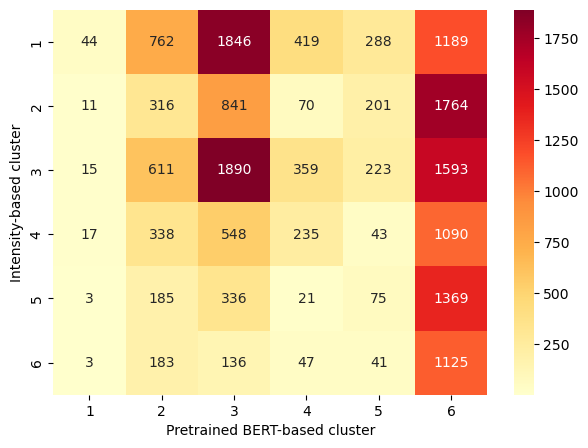

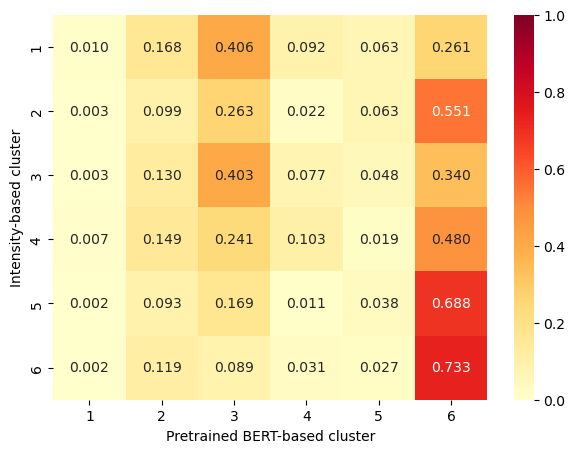

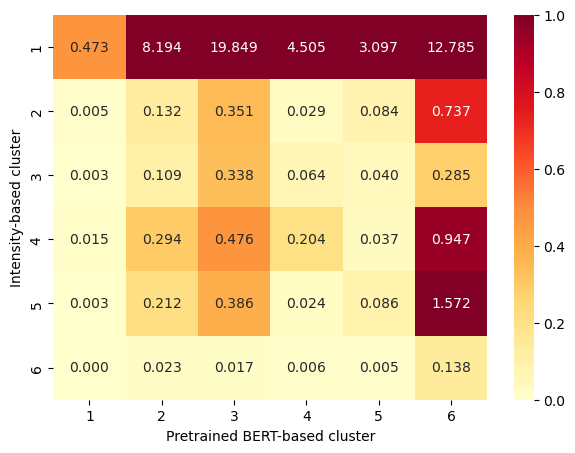

In [10]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
conf_mat = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters))) # confusion matrix
conf_mat_norm_by_row = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row. 
conf_mat_norm_by_column = conf_mat.astype('float') / conf_mat.sum(axis=0)[:, np.newaxis] # Normalize the confusion matrix by row. 

# Heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_row, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_column, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

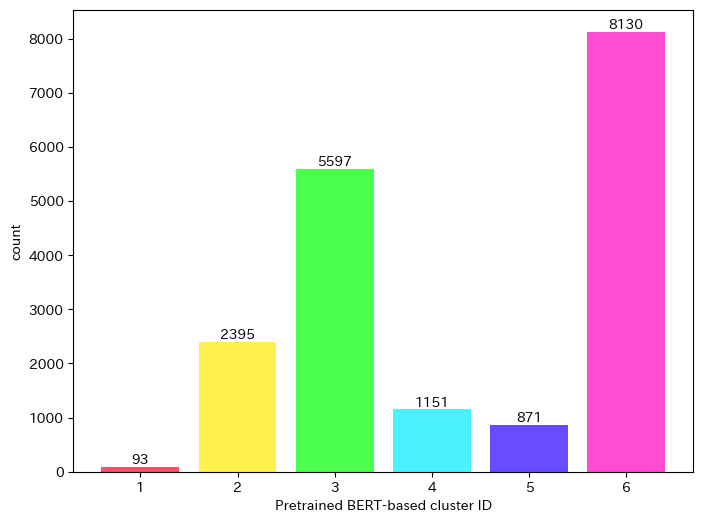

In [11]:
# setting Japanese font
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# frequency of each cluster
cluster_IDs, counts = np.unique(clusters, return_counts=True) # cluster_IDs = [1, 2, 3, 4, 5, 6]

colors = cmap(np.linspace(0, 1, len(cluster_IDs)))

plt.figure(figsize=(8, 6))
bars = plt.bar(cluster_IDs, counts, color=colors, alpha=0.7)
plt.xlabel('Pretrained BERT-based cluster ID')
plt.ylabel('count')
# plt.title(f'Size of Pretrained BERT-based clusters')
plt.xticks(cluster_IDs)

# Display texts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

In [12]:
# Similarity between tweets.

from sklearn.metrics.pairwise import cosine_similarity

target_index = 1 # find similar sentences to this sentence.

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

index: 1
Tweet: 今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
Similarity = 1.0
---
index: 13953
Tweet: 今日も友人と遊んできたのですが､やっぱり休職してるとは､とてもじゃないけど言えないなあと思ってしまいました｡友人が信じられないからとかではなく､やっぱり自分が世間体を気にしてしまっている｡まあ自分から進んで言うような事でもないけど｡難しい｡
Similarity = 0.7185798287391663
---
index: 16504
Tweet: 昨日の夜、会社の体質（というか上司の質）が悲しくて帰り道で泣いた！！みんなで夜中に歌ったりラーメン食べたり楽しかった一年前に戻りたいよ、、、\n\nどうか先輩が今日も明日も、\nたくさんたくさん眠って\nいい夢を見ていますように。
Similarity = 0.6909931302070618
---
index: 13948
Tweet: まだブログ開設できていないのですが､noteとの使い分けを悩み中です｡今のところnoteはコラム(ポエムだろうか…？笑)の位置づけで考えてます｡今は体調優先なので､構想は練りつつ無理なく続けられそうなnoteを継続したい｡余裕があればスタンドfmも｡
Similarity = 0.6906523108482361
---
index: 10339
Tweet: じしん 
Similarity = -0.057101670652627945
---
index: 2596
Tweet: ホワイ
Similarity = -0.045398712158203125
---
index: 10859
Tweet: 無常
Similarity = -0.035734739154577255
---


In [13]:
df_wrime_features_tsne, df_wrime_features_umap = appy_dimensionality_reduction(df_embeddings, clusters)

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/dist

ValueError: cannot assign slice from input of different size

In [ ]:
# t-SNE plot of the pretrained BERT-based embeddings with intensity-based cluster labels. # 吉永君正しいですよね？
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

# Finding the optimal cluster size

In [ ]:
k_max=41

In [ ]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''

In [ ]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

### Plot showing silhouette scores

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [ ]:
# The tweet with the highest silhouette coefficient in each intensity-based cluster
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')

In [ ]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    # print(f'文章カテゴリ: {clusters[index]}')
    # print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    # print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    # print('---')

    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')



### From the embeddings of tweets generated by the pretrained BERT model, infer the intensity-based cluster IDs

In [ ]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters

In [ ]:
# divide into train and test
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

In [ ]:
import xgboost as xgb

# Make input data to xgboost
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

In [ ]:
# Model
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# learning
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# prediciton
preds_labels = model.predict(test_data)

# Visualization
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [ ]:
test_labels += 1
preds_labels += 1

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [ ]:
# Indices of false predictions
false_preds = np.where(test_labels != preds_labels)[0]

# Show the first 5 false predictions
for i in false_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

---